In [1]:
from collections import Counter
import json
import os
import re

from matplotlib import font_manager, rc
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
import pymysql as sql
import pandas as pd

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-2])
JSON_PATH = f'{ROOT_PATH}/utils/configs'

load_json = lambda path: json.loads(open(path, 'r').read())
CONFIGS   = edict(load_json(f'{JSON_PATH}/config.json'))
PORTS     = edict(load_json(f'{JSON_PATH}/ports.json'))

In [3]:
passwd    = CONFIGS.sql_passwd
host      = CONFIGS.global_host
user      = CONFIGS.sql_user
port      = PORTS.sql_port

font_path = '/usr/share/fonts/NanumMyeongjo.ttf'
font      = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

In [4]:
conn  = sql.connect(host = host, user = user, passwd = passwd,
                    port = port, db   = 'DoveNest')
query = 'select * from steam_info'
df    = pd.read_sql(query, conn)

conn.close()
df.info()

/tmp/ipykernel_11604/1152242253.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df    = pd.read_sql(query, conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180502 entries, 0 to 180501
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   idx        180502 non-null  int64 
 1   appid      180502 non-null  int64 
 2   title      180502 non-null  object
 3   thumbnail  180502 non-null  object
 4   genre      180502 non-null  object
 5   price      180502 non-null  object
 6   developer  180502 non-null  object
 7   publisher  180502 non-null  object
 8   windows    180502 non-null  int64 
 9   linux      180502 non-null  int64 
 10  mac        180502 non-null  int64 
 11  languages  180502 non-null  object
 12  date       180502 non-null  object
dtypes: int64(5), object(8)
memory usage: 17.9+ MB


In [5]:
def split_quater(date: str) -> str:

    date        = re.sub('월 [0-9]*일', '', date)
    year, month = date.split('년')
    month       = int(month.replace('월', ''))
    
    if   month in ( 1,  2,  3): quater = '1분기'
    elif month in ( 4,  5,  6): quater = '2분기'
    elif month in ( 7,  8,  9): quater = '3분기'
    elif month in (10, 11, 12): quater = '4분기'
    else: quater = pd.NA

    return f'{year}년 {quater}'


def split_price_range(price: str) -> str:

    price = int(re.sub('[^0-9]*', '', price))
    if price in range(0, 10_000): price = '₩ 0 ~ ₩ 9,999'
    elif price in range(10_000, 20_000): price = '₩ 10,000 ~ ₩ 19,999'
    elif price in range(20_000, 30_000): price = '₩ 20,000 ~ ₩ 29,999'
    elif price in range(30_000, 40_000): price = '₩ 30,000 ~ ₩ 39,999'
    elif price in range(40_000, 50_000): price = '₩ 40,000 ~ ₩ 49,999'
    elif price in range(50_000, 60_000): price = '₩ 50,000 ~ ₩ 59,999'
    elif price in range(60_000, 70_000): price = '₩ 60,000 ~ ₩ 69,999'
    else: price = '₩ 70,000 ~'

    return price


def merge_datas(column, pattern):

    merged_data = []
    for data in df[column]:

        merged_data.extend([re.sub(pattern, '', d) for d in data])

    return merged_data

In [6]:
df           = df.apply(lambda x: x.replace('N/A', pd.NA))
df           = df.apply(lambda x: x.replace(''   , pd.NA))
df           = df.dropna()

df.genre     =             df.genre.apply(lambda x: x.split(','))
df.languages =         df.languages.apply(lambda x: x.split(','))
df.developer = df.developer.apply(lambda x: x.lower().split(','))
df.publisher = df.publisher.apply(lambda x: x.lower().split(','))

df.date      = df.date.apply(split_quater)
df.price     = df.price.apply(split_price_range)
df.sample(3).T

,19285,48691,70288
idx,23915,53321,74918
appid,407920,677090,1387010
title,Contagion OST,Ogre - Deluxe Official Soundtrack,Kings Town
thumbnail,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...
genre,"[액션, 어드벤처, 인디]","[인디, 전략]","[캐주얼, 인디, RPG, 전략, 앞서 해보기]"
price,"₩ 0 ~ ₩ 9,999","₩ 0 ~ ₩ 9,999","₩ 10,000 ~ ₩ 19,999"
developer,"[monochrome, inc]",[auroch digital],[leturs labs]
publisher,"[monochrome, inc]",[auroch digital],[leturs labs]
windows,1,1,1
linux,1,0,0


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83],
 [Text(0, 0, '2000년 4분기'),
  Text(1, 0, '2001년 1분기'),
  Text(2, 0, '2001년 2분기'),
  Text(3, 0, '2001년 4분기'),
  Text(4, 0, '2003년 2분기'),
  Text(5, 0, '2003년 3분기'),
  Text(6, 0, '2003년 4분기'),
  Text(7, 0, '2004년 1분기'),
  Text(8, 0, '2004년 2분기'),
  Text(9, 0, '2004년 4분기'),
  Text(10, 0, '2005년 2분기'),
  Text(11, 0, '2005년 3분기'),
  Text(12, 0, '2005년 4분기'),
  Text(13, 0, '2006년 1분기'),
  Text(14, 0, '2006년 2분기'),
  Text(15, 0, '2006년 3분기'),
  Text(16, 0, '2006년 4분기'),
  Text(17, 0, '2007년 1분기'),
  Text(18, 

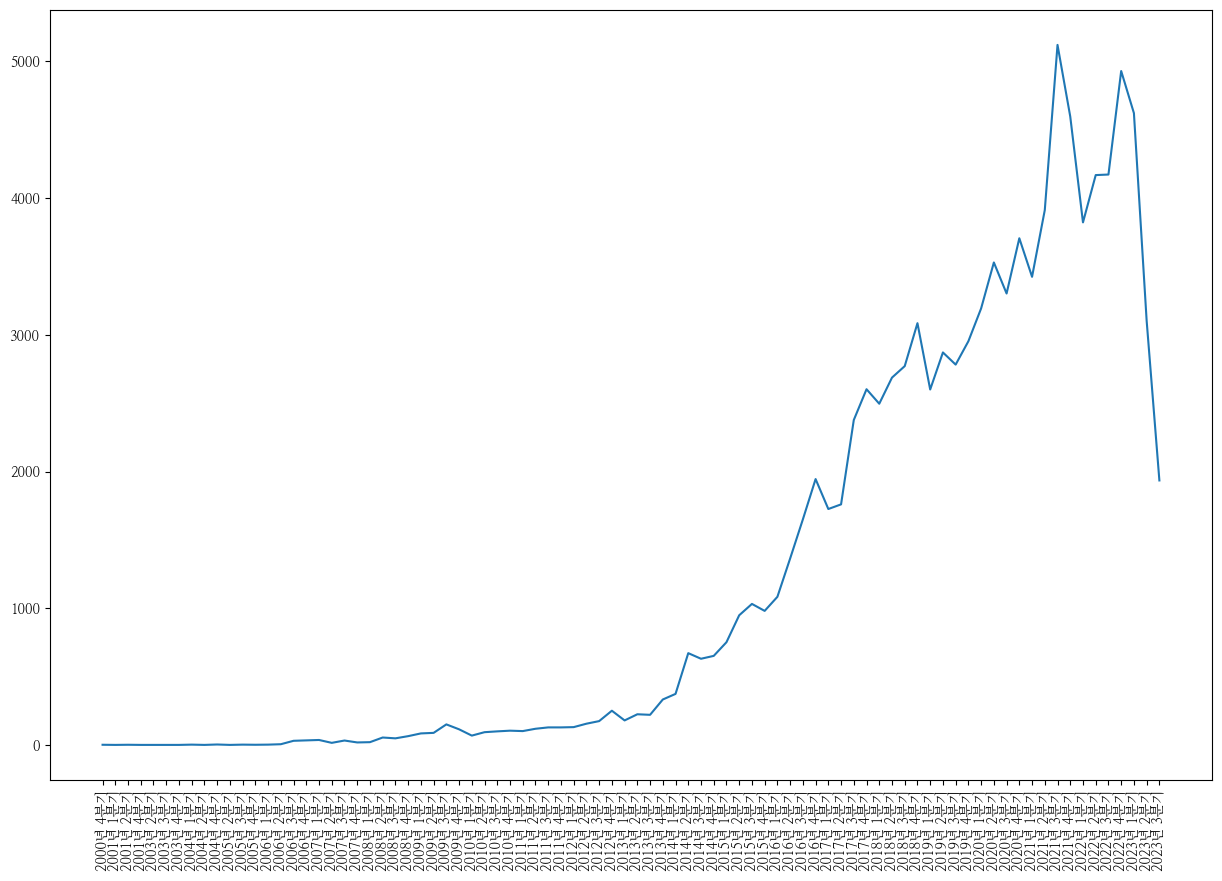

In [7]:
n_dates = df[df.date >= '2000년 1분기']
n_dates = dict(n_dates.date.value_counts())
n_dates = dict(sorted(n_dates.items())[:-1])

plt.figure(figsize = (15, 10))
plt.plot(n_dates.keys(), n_dates.values())
plt.xticks(rotation = 90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'sledgehammergames'),
  Text(1, 0, 'furyucorporation'),
  Text(2, 0, 'playgroundgames'),
  Text(3, 0, 'sokpopcollective'),
  Text(4, 0, 'treyarch'),
  Text(5, 0, 'creativeassembly'),
  Text(6, 0, 'kokororeflections'),
  Text(7, 0, 'capcom'),
  Text(8, 0, 'dharkerstudio'),
  Text(9, 0, 'enginesoftwarebv'),
  Text(10, 0, 'taitocorp'),
  Text(11, 0, 'phgmbh'),
  Text(12, 0, 'ravensoftware'),
  Text(13, 0, 'gearboxsoftware'),
  Text(14, 0, 'aspyrmac'),
  Text(15, 0, 'flatcatgames'),
  Text(16, 0, 'gamesforpleasure'),
  Text(17, 0, 'irstudio'),
  Text(18, 0, 'ayatosoundcreate'),
  Text(19, 0, 'relicentertainment'),
  Text(20, 0, 'scssoftware'),
  Text(21, 0, 'ilca'),
  Text(22, 0, 'colloseusx

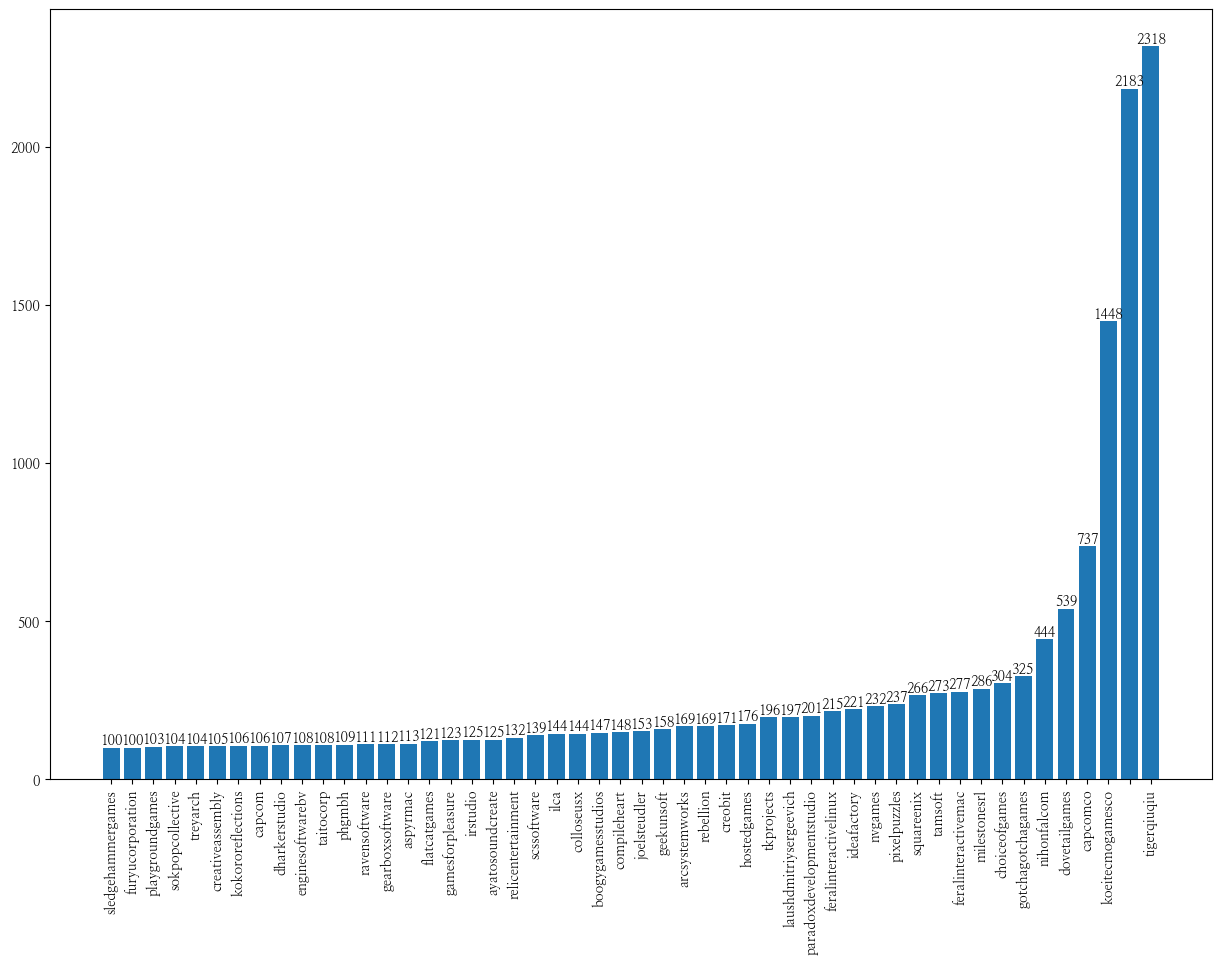

In [8]:
devs_cnt  = Counter(merge_datas('developer', pattern = '[^a-zA-Z]*'))
condition = lambda x: ('ltd' not in x, 'inc' not in x, 'llc' not in x) 
devs_cnt  = {k : v for k,v in devs_cnt.items() if all(condition(k)) and (v >= 100)}
devs_cnt  = dict(sorted(devs_cnt.items(), key = lambda x: x[1]))

plt.figure(figsize = (15, 10))
plt.bar(devs_cnt.keys(), devs_cnt.values())
for k, v in devs_cnt.items():

    plt.text(k, v, v,
             ha = 'center', va = 'bottom')

plt.xticks(rotation = 90)

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, '₩ 0 ~ ₩ 9,999'),
  Text(1, 0, '₩ 10,000 ~ ₩ 19,999'),
  Text(2, 0, '₩ 20,000 ~ ₩ 29,999'),
  Text(3, 0, '₩ 30,000 ~ ₩ 39,999'),
  Text(4, 0, '₩ 40,000 ~ ₩ 49,999'),
  Text(5, 0, '₩ 50,000 ~ ₩ 59,999'),
  Text(6, 0, '₩ 60,000 ~ ₩ 69,999'),
  Text(7, 0, '₩ 70,000 ~')])

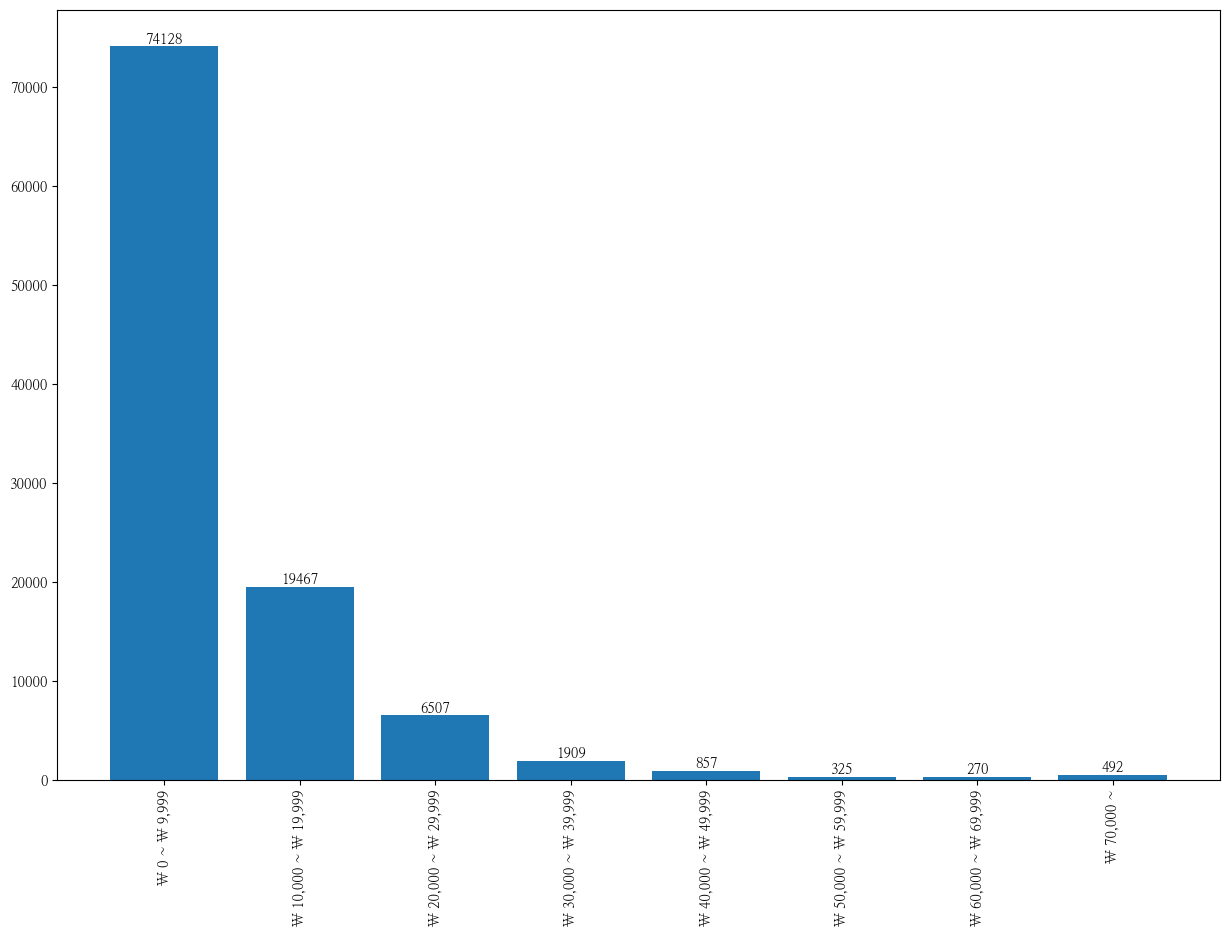

In [9]:
n_prices = dict(df.price.value_counts())
n_prices = dict(sorted(n_prices.items()))

plt.figure(figsize = (15, 10))
plt.bar(n_prices.keys(), n_prices.values())

for k, v in n_prices.items(): plt.text(k, v, v, ha = 'center', va = 'bottom')
plt.xticks(rotation = 90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, '인디'),
  Text(1, 0, '전략'),
  Text(2, 0, '액션'),
  Text(3, 0, '어드벤처'),
  Text(4, 0, '캐주얼'),
  Text(5, 0, '대규모멀티플레이어'),
  Text(6, 0, '무료'),
  Text(7, 0, ''),
  Text(8, 0, '앞서해보기'),
  Text(9, 0, '시뮬레이션'),
  Text(10, 0, '애니메이션과모델링'),
  Text(11, 0, '동영상제작'),
  Text(12, 0, '게임개발'),
  Text(13, 0, '레이싱'),
  Text(14, 0, '에피소드'),
  Text(15, 0, '튜토리얼'),
  Text(16, 0, '스포츠'),
  Text(17, 0, '디자인과일러스트레이션'),
  Text(18, 0, '웹퍼블리싱'),
  Text(19, 0, '유틸리티'),
  Text(20, 0, '신체노출'),
  Text(21, 0, '폭력적'),
  Text(22, 0, '고어'),
  Text(23, 0, '사진편집'),
  Text(24, 0, '교육'),
  Text(25, 0, '영화'),
  Text(26, 0, '다큐멘터리'),
  Text(27, 0, '짧은영상'),
  Text(28, 0, '소프트웨어교육'),
  Text(29, 0, '오디오제작'),
  Text(30, 0, '선정적인내용'),
  Text(31, 0, '회계업무'),
  Text(32, 0, '동영상')])

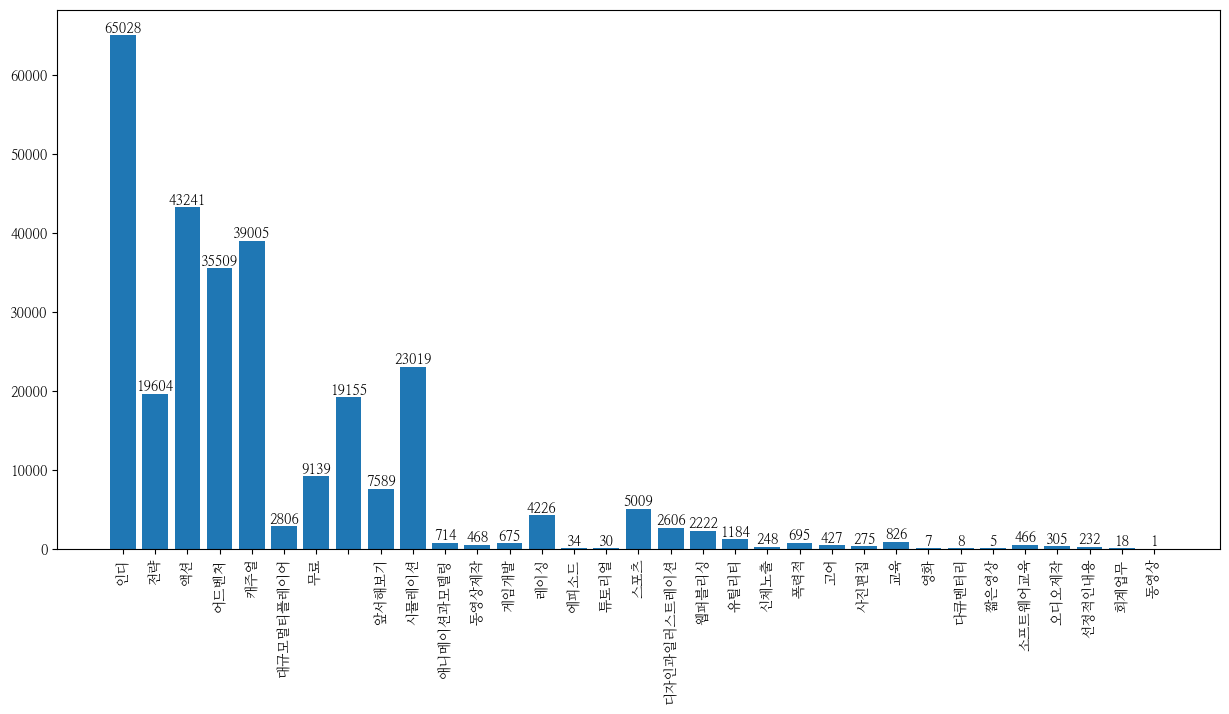

In [10]:
genre_cnt = Counter(merge_datas('genre', pattern = '[^가-힣]*'))

plt.figure(figsize = (15, 7))
plt.bar(genre_cnt.keys(), genre_cnt.values())

for k, v in genre_cnt.items(): plt.text(k, v, v, ha = 'center', va = 'bottom')
plt.xticks(rotation = 90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107],
 [Text(0, 0, '영어'),
  Text(1, 0, '프랑스어'),
  Text(2, 0, '이탈리아어'),
  Text(3, 0, '독일어'),
  Text(4, 0, '스페인어스페인'),
  Text(5, 0, '일본어'),
  Text(6, 0, '한국어'),
  Text(7, 0, '포르투갈어포르투갈'),
  Text(8, 0, '러시아어'),
  Text(9, 0, '중국어간체'),
  Text(10, 0, '중국어번체'),
  Text(11, 0, '우크라이나어'),
  Text(12, 0, '포르투갈어브라질'),
  Text(13, 0, '폴란드어'),
  Text(14, 0, '덴마크어'),
  Text

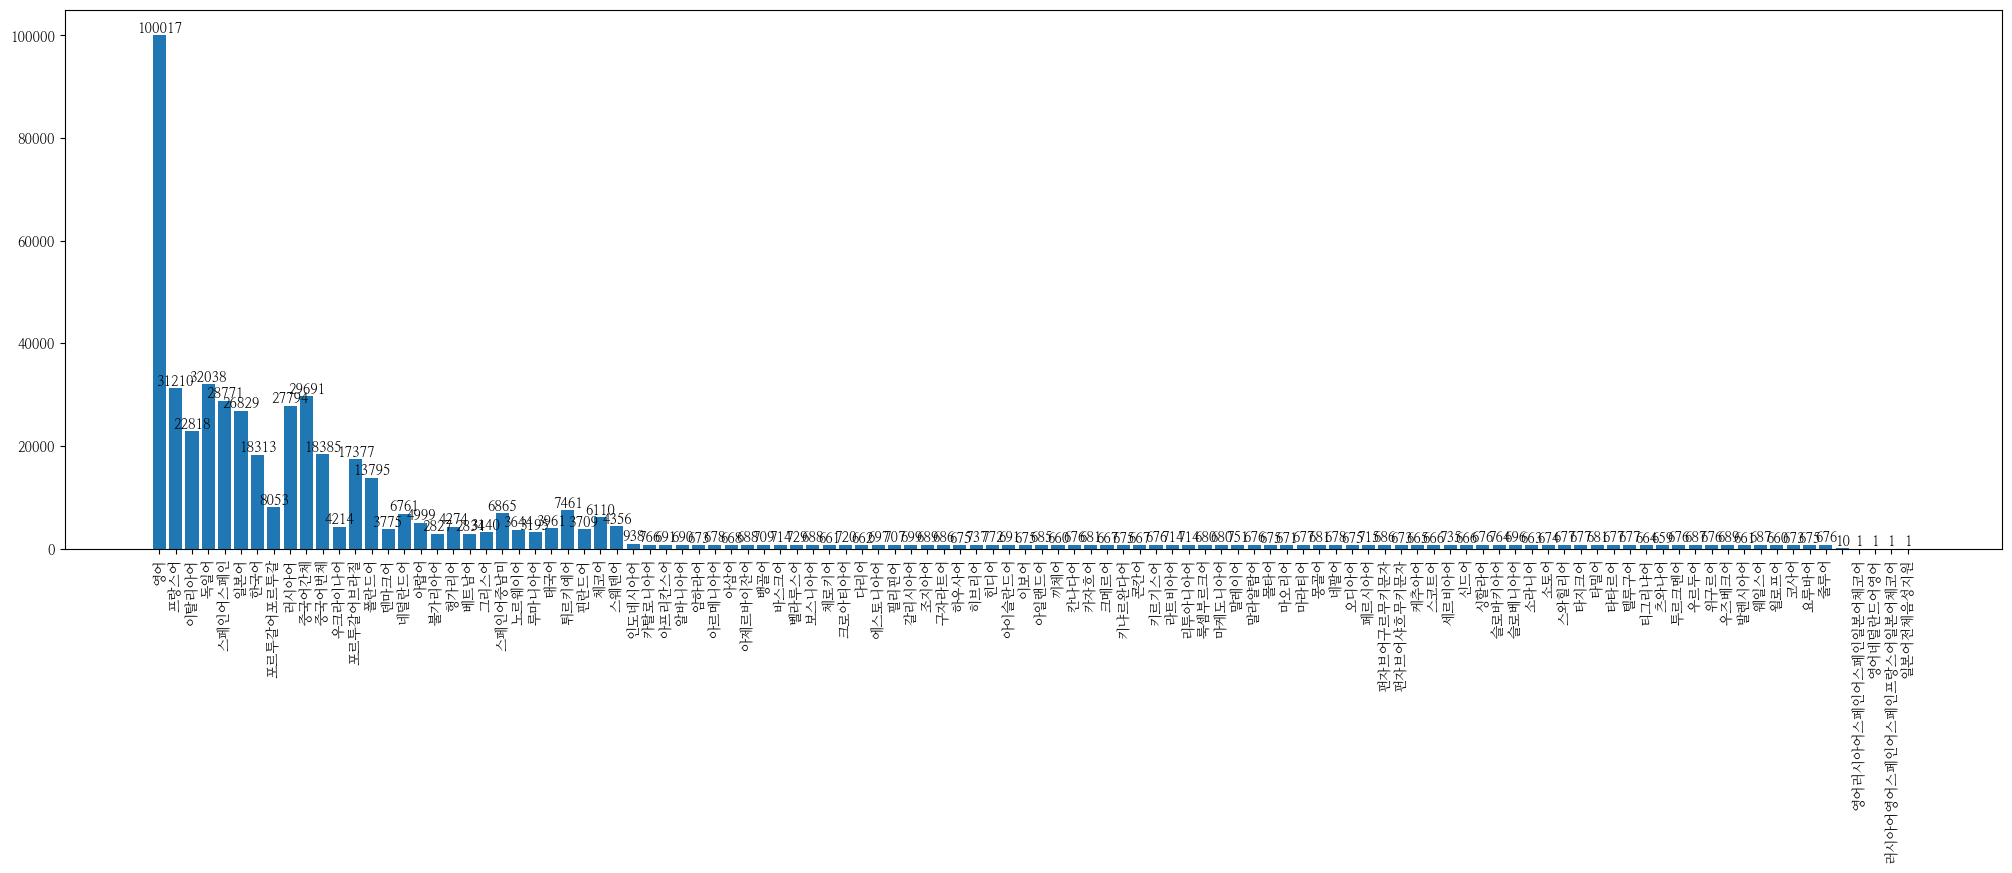

In [11]:
languages_cnt = Counter(merge_datas('languages', pattern = '[^가-힣]*'))

plt.figure(figsize = (25, 7))
plt.bar(languages_cnt.keys(), languages_cnt.values())

for k, v in languages_cnt.items(): plt.text(k, v, v, ha = 'center', va = 'bottom')
plt.xticks(rotation = 90)